## SARIMA Model Creation & Forecasting

- The strong autocorrelation for the room occupancy time series, suggest an autoregressive model such as ARMA or ARIMA or SARIMA
- The occupancy history is non-stationary and there is an upward trend, so the integrated component of ARIMA will automatically perform the differencing needed to transform the data into stationary data. So preferable to ARMA
- The strong seasonality suggests SARIMA would be most appropriate as it can process seasonal patterns. So preferable to ARIMA

SARIMA

- nb to be clear SARIMA stands for Seasonal Autoregressive Integrated Moving Average
- S: seasonal component, here handle the annual occupancy seasonality
- AR: autoregressive component .... p
- I: integrated, here handle the positive historical trend through differencing to make it stationary .... d
- MA: moving average component ...... q
- SARIMA(p,d,q)(P,D,Q),m
- p,d,q non-seasonal
- P,D,Q seasonal
- m the seasonality period, length of the seasonal cycle
- !! But this is daily, with an annual cycle so would be m=365 which is too large ??

Residuals etc

- Residuals plot
- ACF plot of residuals
- Durbin-Watson of residuals
- Use accuracy measures MAE, RMSE, MAPE

Approach

- Confirm/Assess the autoregressive order (AR, p) and moving average order (MA, q). Using PACF plot and ACF plot respectively [repeat autocorrelation findings from previously?]
- Use the SARIMA(p,d,q)(P,D,Q,m) model
- Identify the best parameters using Auto Arima and using AIC (Akaike Information Criterion) to compare



### Data Load & SARIMA Model Factors

- Load time series data
- Assess the autoregressive order (AR, p) - Using PACF plot
- Assess moving average order (MA, q) - Using ACF plot 


In [1]:
# Libraries
#

import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf, pacf_ols
from statsmodels.stats.stattools import durbin_watson

import statsmodels.api as sm

import pmdarima as pm

import matplotlib.pyplot as plt
plt.style.use('ggplot') 
from pandas.plotting import lag_plot


In [2]:
# Establish valid data file path, for reading and saving eg CSV files
#

import os
data_directory = 'Data_Sources'          # Designated data folder above the current working directory
project_directory = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(project_directory, data_directory)
if not os.path.isdir(DATA_PATH):
    raise Exception(f'Directory not found: {DATA_PATH}')

del data_directory, project_directory

In [3]:
# Load the time series CSV
#

# Load the states .csv file, exit if do not exist or are invalid
file_name = 'hotel_timeseries.csv'
file_path = os.path.join(DATA_PATH, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')
hotel_time_series_df = pd.read_csv(file_path, parse_dates=['Date'])
hotel_time_series_df.set_index('Date', inplace=True)

# Tidy Up
del file_name, file_path

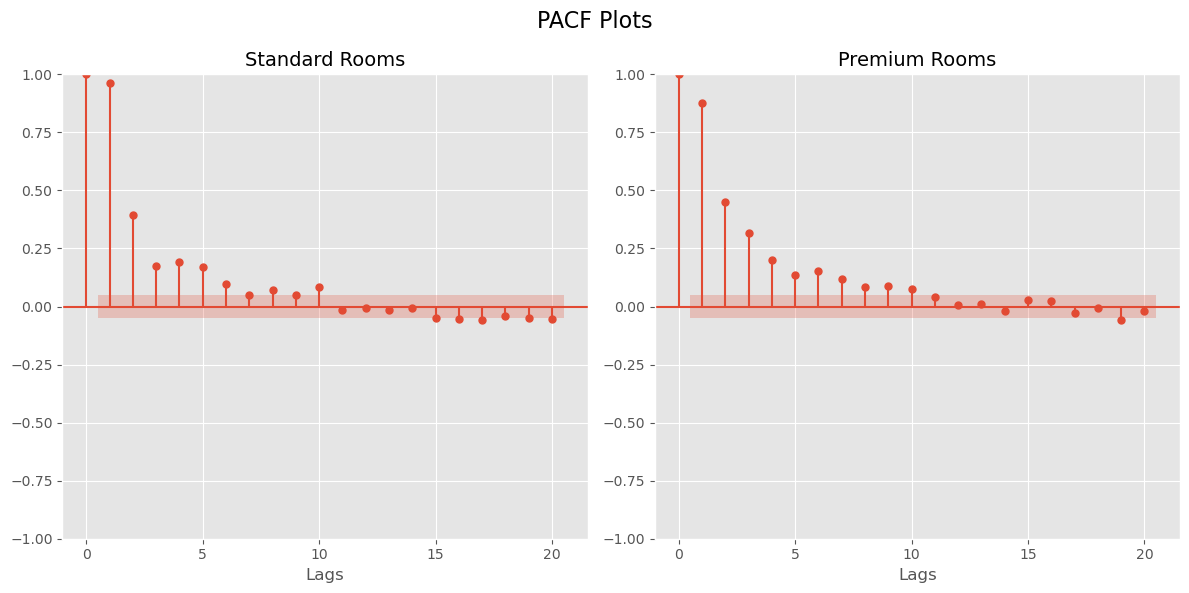

In [6]:
#| label: PACF-plot
#| fig-cap: Partial Autocorrelation Function Plot

# Assess the autoregressive order (AR, p) - Using PACF plot
#

lag_value = 20

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('PACF Plots', fontsize=16)

# Plot for Standard Rooms
plot_pacf(hotel_time_series_df['Standard_OCC'], lags=lag_value, ax=ax1)
ax1.set_title('Standard Rooms', fontsize=14)
ax1.set_xlabel('Lags', fontsize=12)
#ax1.set_ylabel('PACF', fontsize=12)

# Plot for Premium Rooms
plot_pacf(hotel_time_series_df['Premium_OCC'], lags=lag_value, ax=ax2)
ax2.set_title('Premium Rooms', fontsize=14)
ax2.set_xlabel('Lags', fontsize=12)
#ax2.set_ylabel('PACF', fontsize=12)

plt.tight_layout()
plt.show()

PACF plot suggests AR order, p of approximately 3

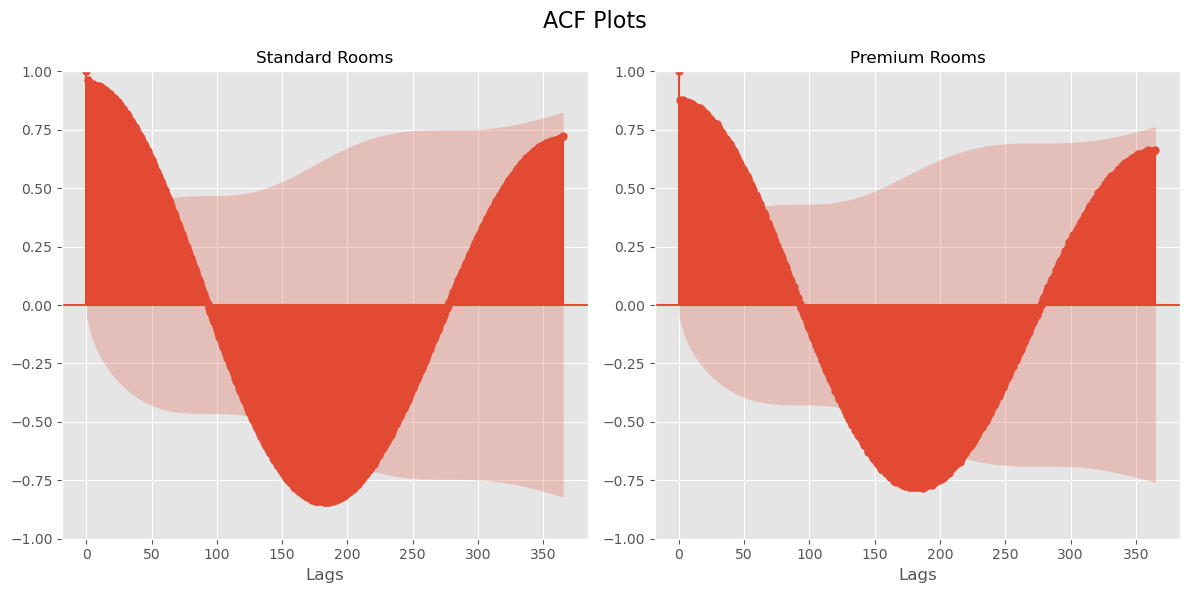

In [5]:
# Assess moving average order (MA, q) - Using ACF plot
#

lag_value = 365

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('ACF Plots', fontsize=16)

# Plot for Standard Rooms
plot_acf(hotel_time_series_df['Standard_OCC'], lags=lag_value, ax=ax1)
ax1.set_title('Standard Rooms', fontsize=12)
ax1.set_xlabel('Lags', fontsize=12)

# Plot for Premium Rooms
plot_acf(hotel_time_series_df['Premium_OCC'], lags=lag_value, ax=ax2)
ax2.set_title('Premium Rooms', fontsize=12)
ax2.set_xlabel('Lags', fontsize=12)

plt.tight_layout()
plt.show()

ACF plot suggests MA order q of approximately 60

### Create the SARIMA Model

- Save the training dataset to be used to train a SARIMA model, in a separate notebook
- Load the model in here for forecasting


In [ ]:
# Define the training and evaluation datasets, save for separate SARIMA model creation

# Daily data, with set aside  for testing
historical_data = hotel_time_series_df['Standard_OCC'][:]

forecast_horizon = 365 # Reserve the last 365 days, 1 year for testing
training_data = historical_data[:-forecast_horizon]
testing_data = historical_data[-forecast_horizon:]

# Save the training & testing data for separate model training
%store training_data testing_data


In [9]:
# Load a saved SARIMA model that was created in a separate notebook
# Due to the length of time needed to create the model and avoid rerunning

%store -r model_sarima_manual


### Forecast Using the SARIMA Model


In [ ]:
# Create a forecast using the SARIMA model for the given time steps
#

# Actual values for the testing data
actual_dates = hotel_time_series_df.index
actual_values = hotel_time_series_df['Standard_OCC']

# Create a forecast for specified time steps beyond the actual time series
forecast_steps = 60         
forecast_dates = pd.date_range(actual.index[-1], periods=forecast_steps + 1, freq='D')[1:]

forecast = model_sarima_manual.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the historical data, forecast, and confidence interval
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title(f'Forecast', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')
# Three line plots
ax1.plot(actual_dates, actual_values, color='blue', linewidth=1, label='Actual')
ax1.plot(forecast_dates, forecast_values, color='red', label='Forecast')
ax1.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1],
                  color='pink', alpha=0.3, label='Confidence Interval')
# Legend
ax1.legend(loc='upper left', facecolor='white')
plt.show()
